# Artificial Intelligence Engineer Nanodegree - Probabilistic Models


## Sign Language Recognition System

- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 Improve the WER with Language Models](#part4_info)

## Intro

The goal of this project is to build a word recognizer for [American Sign Language] video sequences, demonstrating the power of probabalistic models.  

![asl](/files/img/asl.png)

In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of [American Sign Language (ASL) (The [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)). 

In this video, the **right-hand x and y locations are plotted as the speaker signs the sentence**:
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw, train, and test datasets are pre-defined.  We will:
1. **Part 1:** Derive a variety of feature sets.
2. **Part 2:** Implement three different model selection criterion to determine the optimal number of hidden states for each word model.
3. **Part 3:**  Implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria. 

At the end of each Part, we will have completed the submission cells with correct implementations, answer all questions, and pass the unit tests, then submit the code to Udacity!

## Data

### Features Tutorial

##### Load the initial database

A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module. 

In [1]:
from asl_data import AslDb

This handler creates the initial [`pandas`](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `/data` directory as well as dictionaries suitable for extracting data in a format friendly to the [`hmmlearn`](https://hmmlearn.readthedocs.io/en/latest/) library, which we will use to create models in Part 2. We'll also import `numpy` to do some faster array transforms.

In [2]:
import numpy as np
import pandas as pd

In [ ]:
$ pip install git+https://github.com/hmmlearn/hmmlearn.git # recommended

To start, let's set up the initial database and select an example set of features for the training set: 

In [3]:
asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [4]:
asl.df.ix[98,1]  # look at the data available for video 98, at the first frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

The frame above is what is represented in that row of the dataset: **video 98, frame 1.**

##### Feature selection for training the model
The objective of feature selection when training a model is to **choose the most relevant variables while keeping the model as simple as possible**, thus reducing training time.  

In [5]:
asl.df.head(n=3)  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1

##### Feature generation for training the model
We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. Let's start with our first feature:

**`'grnd-ry'`**: The difference between the right-hand y value and the nose y value, which serves as the **"ground" right y value**. 

In [6]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']

In [7]:
asl.df.head(n=3)  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113

Let's make some more ground features!

* **`'grnd-rx'`**: The difference between the left-hand x value and the nose y value, which serves as the **"ground" left y value**. 
* **`'grnd-ly'`**: The difference between the left-hand y value and the nose y value, which serves as the **"ground" * left y value**. 
* **`'grnd-lx'`**: The difference between the left-hand x value and the nose y value, which serves as the **"ground" left x value**. 

In [8]:
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

asl.df.head(n=3)  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12

In [9]:
# Let's test them too!
from asl_utils import test_features_tryit

# test the dataset
test_features_tryit(asl) 

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [10]:
# Collect the ground features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']

# show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground] # List of ground features with lookup by ix (video 98, frame 1)

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set. Each word in the training set has multiple examples from various videos.

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module:

In [11]:
asl.build_training(features_ground)

In [12]:
training = asl.build_training(features_ground) # build_training

##### Explore the training set
We can use multiple pre-built variables and methods to explore this dataset and process the strings related to the ground features. 

In this example, notice that there are two lists:

1. A concatenation of all the sequences (the X portion).
2. A list of the sequence lengths (the Lengths portion).

**`words`**: See the unique words that have been loaded into the training set.

In [13]:
training.words

['JOHN',
 'WRITE',
 'HOMEWORK',
 'IX-1P',
 'SEE',
 'YESTERDAY',
 'IX',
 'LOVE',
 'MARY',
 'CAN',
 'GO',
 'GO1',
 'FUTURE',
 'GO2',
 'PARTY',
 'FUTURE1',
 'HIT',
 'BLAME',
 'FRED',
 'FISH',
 'WONT',
 'EAT',
 'BUT',
 'CHICKEN',
 'VEGETABLE',
 'CHINA',
 'PEOPLE',
 'PREFER',
 'BROCCOLI',
 'LIKE',
 'LEAVE',
 'SAY',
 'BUY',
 'HOUSE',
 'KNOW',
 'CORN',
 'CORN1',
 'THINK',
 'NOT',
 'PAST',
 'LIVE',
 'CHICAGO',
 'CAR',
 'SHOULD',
 'DECIDE',
 'VISIT',
 'MOVIE',
 'WANT',
 'SELL',
 'TOMORROW',
 'NEXT-WEEK',
 'NEW-YORK',
 'LAST-WEEK',
 'WILL',
 'FINISH',
 'ANN',
 'READ',
 'BOOK',
 'CHOCOLATE',
 'FIND',
 'SOMETHING-ONE',
 'POSS',
 'BROTHER',
 'ARRIVE',
 'HERE',
 'GIVE',
 'MAN',
 'NEW',
 'COAT',
 'WOMAN',
 'GIVE1',
 'HAVE',
 'FRANK',
 'BREAK-DOWN',
 'SEARCH-FOR',
 'WHO',
 'WHAT',
 'LEG',
 'FRIEND',
 'CANDY',
 'BLUE',
 'SUE',
 'BUY1',
 'STOLEN',
 'OLD',
 'STUDENT',
 'VIDEOTAPE',
 'BORROW',
 'MOTHER',
 'POTATO',
 'TELL',
 'BILL',
 'THROW',
 'APPLE',
 'NAME',
 'SHOOT',
 'SAY-1P',
 'SELF',
 'GROUP',
 'JA

**`num_items`**: Retrieve number of words in the dataset.

In [14]:
training.num_items

112

**`get_word_sequences('word:str')`**: Get all the sequences of frames where a specific word was signed, as a list of sequences. 

In [15]:
training.get_word_sequences('CHOCOLATE')

[[[-11, 48, 7, 120],
  [-11, 48, 8, 109],
  [-8, 49, 11, 98],
  [-7, 50, 7, 87],
  [-4, 54, 7, 77],
  [-4, 54, 6, 69],
  [-4, 54, 6, 69],
  [-13, 52, 6, 69],
  [-13, 52, 6, 69],
  [-8, 51, 6, 69],
  [-8, 51, 6, 69],
  [-8, 51, 6, 69],
  [-8, 51, 6, 69],
  [-8, 51, 6, 69],
  [-10, 59, 7, 71],
  [-15, 64, 9, 77],
  [-17, 75, 13, 81]],
 [[-4, 48, -4, 113],
  [-2, 53, -4, 113],
  [-4, 55, 2, 98],
  [-4, 58, 2, 98],
  [-1, 59, 2, 89],
  [-1, 59, -1, 84],
  [-1, 59, -1, 84],
  [-7, 63, -1, 84],
  [-7, 63, -1, 84],
  [-7, 63, 3, 83],
  [-7, 63, 3, 83],
  [-7, 63, 3, 83],
  [-7, 63, 3, 83],
  [-7, 63, 3, 83],
  [-7, 63, 3, 83],
  [-7, 63, 3, 83],
  [-4, 70, 3, 83],
  [-4, 70, 3, 83],
  [-2, 73, 5, 90],
  [-3, 79, -4, 96]],
 [[-15, 98, 13, 135],
  [-6, 93, 12, 128],
  [-2, 89, 14, 118],
  [5, 90, 10, 108],
  [4, 86, 7, 105],
  [4, 86, 7, 105],
  [4, 86, 13, 100],
  [-3, 82, 14, 96],
  [-3, 82, 14, 96],
  [6, 89, 16, 100],
  [6, 89, 16, 100],
  [7, 85, 17, 111]]]

**`get_all_word_Xlengths('word:str')`**: For each sequence, retrieve the sequences lengths, or number of frames. (*Note*: We will need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library later.)

In [16]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

**`get_all_sequences()`**: Get all frames in the dataset where *any* word is being signed, as a feature list of frame sequences. Essentially the entire open dictionary. 

In [17]:
training.get_all_sequences()

{'ALL': [[[-64, 36, 31, 180],
   [-64, 36, 31, 180],
   [-64, 36, 31, 180],
   [-64, 36, 31, 180],
   [-71, 39, 31, 180],
   [-71, 39, 31, 180],
   [-76, 43, 31, 180],
   [-76, 43, 31, 180],
   [-60, 39, 35, 181],
   [-60, 39, 34, 177],
   [-54, 26, 32, 177],
   [-47, 23, 27, 169]],
  [[-62, 35, 22, 181],
   [-81, 29, 19, 182],
   [-92, 27, 17, 181],
   [-97, 28, 17, 181],
   [-97, 28, 17, 181],
   [-86, 21, 17, 181],
   [-68, 22, 21, 184],
   [-49, 18, 24, 183],
   [-38, 15, 25, 181],
   [-31, 9, 25, 181],
   [-28, 8, 28, 180]]],
 'ANN': [[[11, 115, -10, 131],
   [10, 100, -10, 131],
   [5, 87, -10, 131],
   [2, 76, -10, 131],
   [4, 68, -10, 131],
   [0, 61, -10, 131],
   [-1, 53, -10, 131],
   [-4, 46, -10, 131],
   [-5, 43, -10, 131],
   [-10, 38, -10, 131],
   [-15, 36, -10, 131],
   [-15, 36, -10, 131],
   [-15, 36, 0, 123]]],
 'APPLE': [[[-13, 15, -12, 130],
   [-15, 14, -14, 129],
   [-15, 13, -14, 128],
   [-17, 13, -16, 128],
   [-17, 14, -16, 129]],
  [[-14, 14, -11, 129],
 

**`get_all_Xlengths()`**: Get the count of total frames in each sequence.

In [18]:
training.get_all_Xlengths()

{'ALL': (array([[-64,  36,  31, 180],
         [-64,  36,  31, 180],
         [-64,  36,  31, 180],
         [-64,  36,  31, 180],
         [-71,  39,  31, 180],
         [-71,  39,  31, 180],
         [-76,  43,  31, 180],
         [-76,  43,  31, 180],
         [-60,  39,  35, 181],
         [-60,  39,  34, 177],
         [-54,  26,  32, 177],
         [-47,  23,  27, 169],
         [-62,  35,  22, 181],
         [-81,  29,  19, 182],
         [-92,  27,  17, 181],
         [-97,  28,  17, 181],
         [-97,  28,  17, 181],
         [-86,  21,  17, 181],
         [-68,  22,  21, 184],
         [-49,  18,  24, 183],
         [-38,  15,  25, 181],
         [-31,   9,  25, 181],
         [-28,   8,  28, 180]], dtype=int64), [12, 11]),
 'ANN': (array([[ 11, 115, -10, 131],
         [ 10, 100, -10, 131],
         [  5,  87, -10, 131],
         [  2,  76, -10, 131],
         [  4,  68, -10, 131],
         [  0,  61, -10, 131],
         [ -1,  53, -10, 131],
         [ -4,  46, -10, 131],

###### Generate more feature sets
So far we have a simple feature set, which is is enough started modeling. **However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and generate some other options now for experimentation later.**

For example, **one of the things that could yield much better results is *normalizing* the data**. For this dataset, it would be useful to normalize over each speaker's range of motion, so we can only look at outliers to the data, i.e. the sign language movements. 

We can do this using grouped statistics, as conveniently implemented in [`pandas` stat(http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions] and the [`pandas` dataset method: `groupby()`.](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html). Functions like `mean()`, `std()`, and others which help refine probabilistic distributions and (hopefully) make our sample distribution more similar to the population distribution. 

The first step in doing that is finding the means by a dimension, such as the **speaker subgroups**: 

In [19]:
df_means = asl.df.groupby('speaker').mean() # Get mean for every speaker
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To match these aggregate means summarizing each speaker, we need use the `pandas` [map()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method, which assigns every row the correct mean. 

In [20]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x']) # For the left hand x coordinate mean map onto rows
asl.df.head() # That's why we get the same value for every row

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

Now let's use the same logic to generate standard deviations using `std()`, which is the other component of the normalization equation.

In [21]:
from asl_utils import test_std_tryit

df_std = asl.df.groupby('speaker').std()
df_std

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


In [22]:
# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


### Feature Implementation
Here, we implement four feature sets that may aid our model's predictive capabilities:

#### Normalized Cartesian coordinates:
Here, we use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length

In [23]:
# Features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

# Mu of left hand (x,y) coords
asl.df['mean_lx'] = asl.df['speaker'].map(df_means['left-x'])
asl.df['mean_ly'] = asl.df['speaker'].map(df_means['left-y'])

# Mu of right hand (x,y) coords
asl.df['mean_rx'] = asl.df['speaker'].map(df_means['right-x'])
asl.df['mean_ry'] = asl.df['speaker'].map(df_means['right-y'])

# Sigma of left hand (x,y) coords
asl.df['std_lx'] = asl.df['speaker'].map(df_std['left-x'])
asl.df['std_ly'] = asl.df['speaker'].map(df_std['left-y'])

# Sigma of right hand (x,y) coords
asl.df['std_rx'] = asl.df['speaker'].map(df_std['right-x'])
asl.df['std_ry'] = asl.df['speaker'].map(df_std['right-y'])

In [24]:
# Normalized left hand (x,y) coords
asl.df['norm-lx']= (asl.df['left-x'] - asl.df['mean_lx']) / asl.df['std_lx']
asl.df['norm-rx']= (asl.df['right-x'] - asl.df['mean_rx']) / asl.df['std_rx']

# Normalized right hand (x,y) coords
asl.df['norm-ly']= (asl.df['left-y'] - asl.df['mean_ly']) / asl.df['std_ly']
asl.df['norm-ry']= (asl.df['right-y'] - asl.df['mean_ry']) / asl.df['std_ry']

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

In [25]:
asl.df.head()[features_norm]

norm-rx   norm-ry   norm-lx   norm-ly
video frame                                        
98    0      1.153232  1.663433 -0.891199  0.741835
      1      1.153232  1.663433 -0.891199  0.741835
      2      1.153232  1.663433 -0.891199  0.741835
      3      1.153232  1.663433 -0.891199  0.741835
      4      1.153232  1.663433 -0.891199  0.741835

#### Polar coordinates:
Now, let's calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates). We can use the [`np.arctan2()`](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

In [26]:
# Add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle (so use hypot and arctan)


asl.df['polar-rr'] = np.sqrt(asl.df['grnd-rx']**2 + asl.df['grnd-ry']**2)
asl.df['polar-lr'] = np.sqrt(asl.df['grnd-lx']**2 + asl.df['grnd-ly']**2)
asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'], asl.df['grnd-ry'])
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'], asl.df['grnd-ly'])

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

#### Delta features:
The difference described in Thad's lecture, use the difference in values between one frame and the next frames as features. [`pandas` has the `diff()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [`fillna()` methods](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html), which helps get this one.

In [27]:
# Add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

asl.df['delta-rx'] = asl.df['right-x'].diff().fillna(0)
asl.df['delta-ry'] = asl.df['right-y'].diff().fillna(0)
asl.df['delta-lx'] = asl.df['left-x'].diff().fillna(0)
asl.df['delta-ly'] = asl.df['left-y'].diff().fillna(0)

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

#### Scaled features:
We use the [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling), which is essentially a computationally faster (but statistically rougher) normalization. 

In [28]:
## Scaled Normalization
asl.df['scaled-rx'] = (asl.df['right-x'] - asl.df['right-x'].min()) / (asl.df['right-x'].max() - asl.df['right-x'].min())
asl.df['scaled-ry'] = (asl.df['right-y'] - asl.df['right-y'].min()) / (asl.df['right-y'].max() - asl.df['right-y'].min())
asl.df['scaled-lx'] = (asl.df['left-x'] - asl.df['left-x'].min()) / (asl.df['left-x'].max() - asl.df['left-x'].min())
asl.df['scaled-ly'] = (asl.df['left-y'] - asl.df['left-y'].min()) / (asl.df['left-y'].max() - asl.df['left-y'].min())

features_scaled = ['scaled-rx', 'scaled-ry', 'scaled-lx', 'scaled-ly']

In [29]:
asl.df.head()[features_scaled]

scaled-rx  scaled-ry  scaled-lx  scaled-ly
video frame                                            
98    0       0.655367   0.668122   0.096154    0.61326
      1       0.655367   0.668122   0.096154    0.61326
      2       0.655367   0.668122   0.096154    0.61326
      3       0.655367   0.668122   0.096154    0.61326
      4       0.655367   0.668122   0.096154    0.61326

Just for fun, let's how scaling compares to true normalization.

In [30]:
asl.df.groupby('speaker').mean()[features_norm + features_scaled]

,norm-rx,norm-ry,norm-lx,norm-ly,scaled-rx,scaled-ry,scaled-lx,scaled-ly
speaker,,,,,,,,
man-1,-4.726264e-16,5.037288e-16,-3.756399e-16,-2.670722e-15,0.573245,0.560572,0.463130,0.821433
woman-1,-6.263690e-16,9.288140e-18,-5.621744e-16,1.797158e-16,0.548124,0.416299,0.196548,0.504261
woman-2,-1.083905e-15,-3.305887e-16,-9.616316e-16,2.322051e-17,0.581166,0.427230,0.315478,0.588548


In [31]:
asl.df.groupby('speaker').std()[features_norm + features_scaled]

,norm-rx,norm-ry,norm-lx,norm-ly,scaled-rx,scaled-ry,scaled-lx,scaled-ly
speaker,,,,,,,,
man-1,1.0,1.0,1.0,1.0,0.106790,0.239748,0.097144,0.200710
woman-1,1.0,1.0,1.0,1.0,0.092994,0.151388,0.112650,0.146931
woman-2,1.0,1.0,1.0,1.0,0.084126,0.173140,0.098646,0.159254


#### Delta normalized features:
Same delta approach, but now using our handy dandy normalized columns. 

In [32]:
## Z-Normalized Delta (difference between z-values)
asl.df['delta-norm-rx'] = asl.df['norm-rx'].diff().fillna(value=0)
asl.df['delta-norm-ry'] = asl.df['norm-ry'].diff().fillna(value=0)
asl.df['delta-norm-lx'] = asl.df['norm-lx'].diff().fillna(value=0)
asl.df['delta-norm-ly'] = asl.df['norm-ly'].diff().fillna(value=0)

features_delta_norm = ['delta-norm-rx', 'delta-norm-ry', 'delta-norm-lx', 'delta-norm-ly']

In [33]:
asl.df.head()[features_delta_norm]

delta-norm-rx  delta-norm-ry  delta-norm-lx  delta-norm-ly
video frame                                                            
98    0                0.0            0.0            0.0            0.0
      1                0.0            0.0            0.0            0.0
      2                0.0            0.0            0.0            0.0
      3                0.0            0.0            0.0            0.0
      4                0.0            0.0            0.0            0.0

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**
* *Z-Normalized Delta*: The difference between z-values. My hypothesis is that this difference might be more useful than trying to process both independent distances, but we'll see once we get a valid WER score. 
* *Scaled Normal*: A faster alternative to the Z-normalized values is what I was told, but I'm surprised by just how different it is to a standard normal. Let's see how it holds up!

In [38]:
all_features = features_ground + features_norm + features_polar + features_delta + features_scaled + features_delta_norm
standard_features = features_ground + features_norm + features_polar + features_delta
custom_features = features_scaled + features_delta_norm

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [39]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.014s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

## Model Selection

### Model Selection Tutorial

The objective of **Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.**

In this section you will explore three methods for that tuning: 
- **CV**: Log likelihood via Cross-Validation folds
- **BIC**: Bayesian Information Criterion 
- **DIC**: Discriminative Information Criterion

##### Train a single word

Now that we have built a training set with sequence data:

In [40]:
asl.df.columns

Index(['left-x', 'left-y', 'right-x', 'right-y', 'nose-x', 'nose-y', 'speaker',
       'grnd-ry', 'grnd-rx', 'grnd-ly', 'grnd-lx', 'left-x-mean', 'mean_lx',
       'mean_ly', 'mean_rx', 'mean_ry', 'std_lx', 'std_ly', 'std_rx', 'std_ry',
       'norm-lx', 'norm-rx', 'norm-ly', 'norm-ry', 'polar-rr', 'polar-lr',
       'polar-rtheta', 'polar-ltheta', 'delta-rx', 'delta-ry', 'delta-lx',
       'delta-ly', 'scaled-rx', 'scaled-ry', 'scaled-lx', 'scaled-ly',
       'delta-norm-rx', 'delta-norm-ry', 'delta-norm-lx', 'delta-norm-ly'],
      dtype='object')

we can "train" models for each word. 

As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).

By using the `fit` method during training, the **[Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model (*for the number of hidden states specified*) from a group of sample seequences**. 

For this example, we *assume* the correct number of hidden states is 3, but that is just a guess. How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameters!

In [64]:
import warnings # supress warnings
from hmmlearn.hmm import GaussianHMM # Grab the Guassian Hidden Markov Model

def train_a_word(word, num_hidden_states, features):
    warnings.filterwarnings("ignore", category=DeprecationWarning) # shhh
    training = asl.build_training(features) # Build the training dataset
    X, lengths = training.get_word_Xlengths(word) # Get the feature vectors, and their lengths
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths) # Fit them to the HMM with the EM algo
    logL = model.score(X, lengths) # Score the model using just that word
    return model, logL # Return the model and the log Loss for the word

We've built a function to train this Markov model with just one word, by retrieving the sequences (and lengths) of just a single word. 

Let's see how it trains: 

In [65]:
demoword = 'CHOCOLATE'
model, logL = train_a_word(demoword, 3, features_ground)

print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
logL = -601.3291470028621


The HMM model has been trained (!) and information can be pulled from the model, including means and variances for each feature and hidden state.  

In [66]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components)) # pretty log
    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)]) # grab the covariance matrices
    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i)) # Number of hidden states in the machine (3) 
        print("mean = ", model.means_[i]) # Means of each state
        print("variance = ", variance[i]) # Variance of each state 
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ -5.40587658  60.1652424    2.32479599  91.3095432 ]
variance =  [   7.95073876   64.13103127   13.68077479  129.5912395 ]

hidden state #1
mean =  [   0.58333333   87.91666667   12.75        108.5       ]
variance =  [  39.41055556   18.74388889    9.855       144.4175    ]

hidden state #2
mean =  [ -9.30211403  55.32333876   6.92259936  71.24057775]
variance =  [ 16.16920957  46.50917372   3.81388185  15.79446427]



The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score()` method. 

We can even experiment by changing the feature set, word, and/or the nnmber of hidden states values:

In [67]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_delta) # Experiment here with different parameters

show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [-0.54151701 -0.13549492  0.          0.        ]
variance =  [  7.40033314e+00   2.07610444e-01   4.54757788e-04   4.54757788e-04]

hidden state #1
mean =  [ 0.07434035  4.32590509  1.08475329  2.81908645]
variance =  [ 14.12290048  15.39826602  12.40214192  17.46963045]

hidden state #2
mean =  [ 2.26955318 -0.2690072  -0.67005544 -9.1341518 ]
variance =  [  9.26031519   7.66293533   7.67530134  15.28076516]

logL = -256.56151832675334


In [68]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 10, features_scaled) # Experiment with 10 hidden states

show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 10
hidden state #0
mean =  [ 0.59981167  0.42285299  0.20940171  0.3941068 ]
variance =  [ 0.00073377  0.00116841  0.00075645  0.00141701]

hidden state #1
mean =  [ 0.6909602   0.51703067  0.3352564   0.485636  ]
variance =  [ 0.00145358  0.00114187  0.00138666  0.00205895]

hidden state #2
mean =  [ 0.60538104  0.36266737  0.29273908  0.55656672]
variance =  [ 0.00483165  0.0048187   0.00485312  0.00610241]

hidden state #3
mean =  [ 0.61534057  0.39280604  0.28805558  0.32803624]
variance =  [ 0.00121434  0.00156907  0.00086391  0.00166667]

hidden state #4
mean =  [ 0.59322034  0.55895197  0.33974359  0.64640884]
variance =  [ 0.01  0.01  0.01  0.01]

hidden state #5
mean =  [ 0.62157066  0.36720748  0.31029342  0.46432036]
variance =  [1000. 1000. 1000. 1000.]

hidden state #6
mean =  [ 0.61581916  0.37554589  0.1730771   0.54143609]
variance =  [ 0.01        0.01        0.01000001  0.01000003]

hidden state #7
mean =  [ 0.6440678

Depending on which features we use, different hidden states could be decided upon. That's why we have criteria to check them out.

##### Visualize the hidden states
We can plot the means and variances for each state and feature. 

By trying to vary the number of states trained for the HMM model, we can examine the variances, and see if visually if some models that are "better" than others? The shape of distribution can be very telling about its properties. 

In [92]:
%pylab inline
pylab.rcParams['figure.figsize'] = (6, 6)

Populating the interactive namespace from numpy and matplotlib


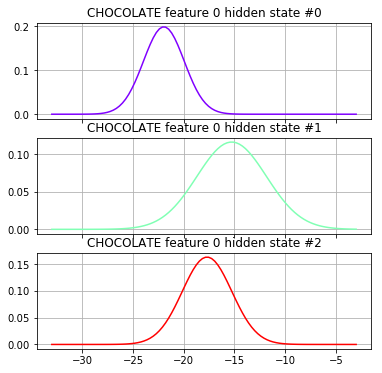

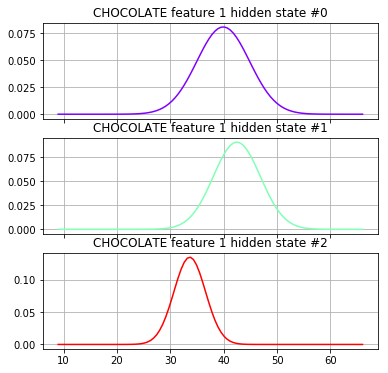

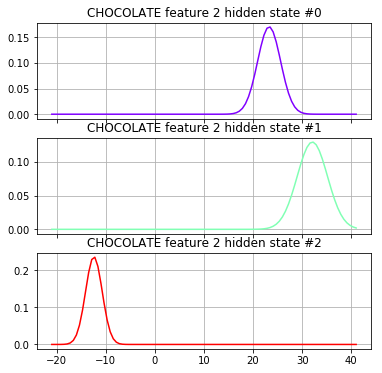

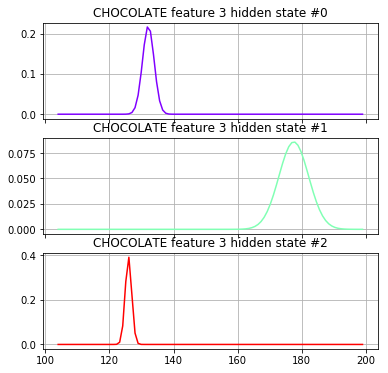

In [94]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

##### Selecting the appropriate hyperparameters (the ModelSelector class)
Let's review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module. 

It is designed to be a [strategy pattern](https://en.wikipedia.org/wiki/Strategy_pattern) for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: Log likelihood with Bayesian Information Criteria BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. 

The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [95]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. 

However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  

**To estimate which topology model is better using only the training data, we can compare scores using cross-validation.**  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold is then scored, whichgives us a proxy method of finding the best model to use on "unseen data". 

In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [96]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [ ]:
%load autoreload
% autoreload 2

In [97]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']

import timeit
from importlib import reload # To force reload of my_model_selectors.py; Jupyter doesn't seem to notice edits well...

import my_model_selectors

<module 'my_model_selectors' from '/Users/vivek.menon/Documents/learn/udacity/AIND/project3-recognizer/AIND-Recognizer/my_model_selectors.py'>

In [98]:
# Using SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 0.4476263079995988 seconds
Training complete for BOOK with 2 states with time 4.839206810000178 seconds
Training complete for VEGETABLE with 2 states with time 2.1927887140000166 seconds
Training complete for FUTURE with 2 states with time 4.4296579419997215 seconds
Training complete for JOHN with 2 states with time 44.56188467899938 seconds


In [99]:
# Using SelectorBIC in my_model_selectors.py
from my_model_selectors import SelectorBIC
reload(my_model_selectors)

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()

for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.37530787699961365 seconds
Training complete for BOOK with 8 states with time 2.361273431999507 seconds
Training complete for VEGETABLE with 9 states with time 0.9268536449999374 seconds
Training complete for FUTURE with 9 states with time 2.8281765499996254 seconds
Training complete for JOHN with 13 states with time 23.39553656299995 seconds


In [100]:
# Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC
reload(my_model_selectors)

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()

for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.38032576700061327 seconds
Training complete for BOOK with 15 states with time 2.3070487420000063 seconds
Training complete for VEGETABLE with 15 states with time 0.7968417069996576 seconds
Training complete for FUTURE with 15 states with time 2.3040386630000285 seconds
Training complete for JOHN with 15 states with time 21.571352362000653 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:** All three of these model selection methods are used to avoid overfitting. CV (Cross-Validation) separates the data into two folds, one for training and the other one for testing. In the normal approach, it merely returns the "fold" witht he best log-likehood score, while the the BIC and DIC criterion attempt to improve the perormance by introducing penalties; for BIC, the penalty term penalizes complexity to avoid oferfitting, and DIC penalizes similar models. In terms of speed, DIC is marginally better BIC which competed with my intution (since the sub loop tests individaul words). It is interesting how one's choice of criterion may significantly influence the success of a model; it seems intuitive to test both of these criteria (and maybe even the AIC?) together. 

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [101]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 63.024s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [ ]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

from my_model_selectors import SelectorConstant

In [44]:
def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

In [102]:
models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [45]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [86]:
# Implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [87]:
# Setting up auto module reloading
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
# Selectors
from my_model_selectors import *

In [89]:
models = {'SelectorConstant':SelectorConstant, 'SelectorCV':SelectorCV, 'SelectorBIC':SelectorBIC, 'SelectorDIC':SelectorDIC}
feature_sets = {'all_features':all_features, 'standard_features':standard_features, 'custom_features':custom_features}

In [90]:
def wordErrorRateChecker(feature_set, model, features, model_selector):
    """
    
    A quick wrapper to iterate over a group of HMM models and different kinds of feature sets. 
    
    """
    print("\n"+ "="*10 + "\nUsing feature set: {}\nUsing model: {}\n".format(feature_set, model) + "="*10)
    
    models = train_all_words(features, model_selector) # train
    test_set = asl.build_test(features) # test
    probabilities, guesses = recognize(models, test_set) # guess
    show_errors(guesses, test_set) # check     

In [91]:
# Let's check some f##cking words yo
[wordErrorRateChecker(feature_set,model,feature_sets[feature_set],models[model]) for feature_set in feature_sets for model in models]

Using feature set: all_features
Using model: SelectorConstant

**** WER = 0.5449438202247191
Total correct: 81 out of 178
Video  Recognized                                                    Correct
    2: *POSS WRITE HOMEWORK                                          JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE *HAVE *ARRIVE                                    JOHN CAN GO CAN
   12: JOHN CAN *WHAT CAN                                            JOHN CAN GO CAN
   21: JOHN *NEW *JOHN *MARY *CAR *CAR *FUTURE *MARY                 JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE IX *WHO IX                                          JOHN LIKE IX IX IX
   28: JOHN *WHO IX *LIKE IX                                         JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: MARY *JOHN *IX *GIVE *MARY *MARY                              MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *MARY *CORN MARY *MARY                                 

[None, None, None, None, None, None, None, None, None, None, None, None]

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

| **Feature Set** | **Model** | **WER**         
| :- |-------------: | :-:
|`all_features`| `SelectorConstant`  | 54%
|`all_features`| `SelectorCV`  | 54%
|`all_features`| `SelectorBIC`  | 44%
|`all_features`| `SelectorDIC`  | 49%
|`standard_features`| `SelectorConstant`  | 57%
|`standard_features`| `SelectorCV`  | 55%
|`standard_features`| `SelectorBIC`  | 47%
|`standard_features`| `SelectorDIC`  | 51%
|`custom_features`| `SelectorConstant`  | 43%
|`custom_features`| `SelectorCV`  | 60%
|`custom_features`| `SelectorBIC`  | 41%
|`custom_features`| `SelectorDIC`  | 44%


| **Model** | **Feature Set** | **WER**         
| :- |-------------: | :-:
| `SelectorConstant`  |`all_features`| 54% | 
| `SelectorConstant`  |`standard_features`| 57% 
| `SelectorConstant`  |`custom_features`|  43%
| `SelectorCV`  |`all_features`| 54%
| `SelectorCV`  |`standard_features`| 55%
| `SelectorCV`  |`custom_features`| 60%
| `SelectorBIC`  |`all_features`| 44%
| `SelectorBIC`  |`standard_features`| 47%
| `SelectorBIC`  |`custom_features`|  41%
| `SelectorDIC`  |`all_features`| 49%
| `SelectorDIC`  |`standard_features`| 51%
| `SelectorDIC`  |`custom_features`|  44%

Originally, all of these WER scores were remarkably terrible. Turns out, I was passing in a list of of character vectors instead of features. Once we had solved for that, the performance improved significantly. I wish I had known that before I rewrote most of this document, but it was a learning experience. 

What I would've said is that the DIC and BIC models are generally on the superior end of the spectrum. This is logical, since their methodologies allow them to find more than a few candidate functions, and therefore improve performance. 

In fact, it seems like they are both answering similar questions in different ways. BIC tries to find the best model among the set of candidates, and DIC tries to find the best model using implicit tests on the data. Generally speaking, they have different strengths and weaknesses, but if I have learnt anything I think it's to pick the most **intuitive criterion for a problem and stick to it**. 

Picking (and training these models) is clearly difficult, but despite completely different feature sets, models, and critera, all the WER scores tended towards similarish performance. Therefore, I propose that maybe most feature sets already encapsulate enough information about the true population distribution, and that the choice of model is perhaps less important than having an intuitive reason (criteria) why a given model should best describe a given distribution. 

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [93]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 38.091s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [94]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()

,ALL,ANN,APPLE,ARRIVE,BILL,BLAME,BLUE,BOOK,BORROW,BOX,...,VIDEOTAPE,VISIT,WANT,WHAT,WHO,WILL,WOMAN,WONT,WRITE,YESTERDAY
0,-15039.823566,-5.959634e+05,-88680.594032,-1301.144513,-171335.652240,-1201.727961,-17454.261479,-2102.757483,-166699.473760,-1334.061894,...,-11172.438740,-913.038055,-2.862745e+05,-1061.309251,-1072.858958,-3.830070e+05,-3188.136043,-1697.339597,-1417.878341,-1133.312666
1,-40807.665828,-4.856835e+06,-167960.327992,-557.397808,-225822.624613,-677.025413,-23379.507266,-689.147502,-338814.416790,-1102.601779,...,-1538.389784,-1031.224546,-1.080084e+05,-906.597600,-1258.747459,-2.262287e+06,-44435.089953,-1708.208404,-377.454215,-2146.002959
2,-64932.499065,-7.902755e+06,-241414.123647,-1142.912652,-337185.087167,-1417.867180,-42159.416512,-2646.170054,-580284.454202,-1998.997944,...,-5247.682178,-1789.366879,-1.348833e+05,-2011.382861,-3924.835768,-2.742907e+06,-22060.741328,-2982.388097,-2644.109239,-3595.684961
3,-8002.653085,-7.712235e+06,-10623.787351,-1093.848316,-31110.087690,-1513.394858,-5204.008518,-3861.372788,-799923.320879,-2057.918657,...,-24678.834952,-1105.705011,-1.387096e+06,-1213.657533,-1930.718992,-3.720675e+05,-1609.965873,-2956.462663,-5024.508629,-2368.622761
4,-8312.183731,-3.459117e+06,-88655.719008,-404.718700,-539452.758236,-282.528173,-3489.372310,-445.056466,-182953.871491,-261.407134,...,-3558.067833,-302.069979,-1.195682e+05,-306.722390,-1061.402447,-3.919745e+05,-12810.333775,-1351.690596,-1635.469378,-1160.618824
